In [1]:
!git clone https://github.com/Palandr1234/NFE.git

Cloning into 'NFE'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 114 (delta 40), reused 91 (delta 20), pack-reused 0
Receiving objects: 100% (114/114), 17.47 MiB | 21.61 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [2]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1zgT5-UOa9oby2mViweBQTaYmhsfwvHje
!gdown https://drive.google.com/uc?id=1XDtGm6NOMYbKzNxKuf83hTLZgvX4n0E3

  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for gdown: filename=gdown-4.5.1-py3-none-any.whl size=14933 sha256=1fd5f404b0c2143c0e5da925c62ead7678c4c72ce7ac6dfd8e26e83cdd807b4d
  Stored in directory: /root/.cache/pip/wheels/3d/ec/b0/a96d1d126183f98570a785e6bf8789fca559853a9260e928e1
Successfully built gdown
Downloading...
From: https://drive.google.com/uc?id=1zgT5-UOa9oby2mViweBQTaYmhsfwvHje
To: /kaggle/working/Generator_v2_150.pth
100%|███████████████████████████████████████| 98.0M/98.0M [00:00<00:00, 165MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XDtGm6NOMYbKzNxKuf83hTLZgvX4n0E3
To: /kaggle/working/Discriminator_v2_150.pth
100%|███████████████████████████████████████| 71.3M/71.3M [00:00<00:00, 191MB/s]


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
from PIL import Image
import glob
import math
import matplotlib.pyplot as plt

from NFE.StyleGAN import *

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
G = torch.load("Generator_v2_150.pth", map_location=device)
D = torch.load("Discriminator_v2_150.pth", map_location=device)

In [6]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        super().__init__()
        self.files = glob.glob(root_dir+"/*")
        self.transform = transform
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image = Image.open(self.files[idx]).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return image

In [7]:
dataroot = "../input/animefacedataset/images"
img_size=64
batch_size = 8
dataset = CustomDataset(root_dir=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize((img_size, img_size)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
class ResBlock(nn.Module):
    def __init__(self,in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 1)
        self.act = nn.LeakyReLU(0.2)
        self.conv1 = nn.Conv2d(in_channels, in_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(in_channels, out_channels, 3, padding=1)

    def forward(self, x):
        return self.act(self.conv(x))+self.act(self.conv2(self.act(self.conv1(x))))

In [9]:
class Encoder(nn.Module):
    def __init__(self, z_dim=512):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), 
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(2),
            ResBlock(64, 128),
            nn.AvgPool2d(2),
            ResBlock(128, 256),
            nn.AvgPool2d(2),
            ResBlock(256, 512),
            nn.AvgPool2d(2),
            ResBlock(512, 1024),
        )   
        self.linear = nn.Linear(1024*4*4, 512)         
  
    def forward(self, x):
        x = self.conv(x)
        x = x.reshape(x.size(0), -1)
        return self.linear(x)

In [10]:
encoder = Encoder().to(device)
lr = 3e-4
optimizer = optim.Adam(encoder.parameters(), lr= lr)
model = torchvision.models.vgg16(pretrained=True).features.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [11]:
z_dim=512
step = int(math.log(z_dim, 2)) -2
criterion = torch.nn.MSELoss()

epochs=10
ce = nn.BCELoss()

In [12]:
losses = []
for epoch in range(epochs):
    loss_epoch = []
    for i, data in enumerate(dataloader, 0):
        data = data.to(device)
        optimizer.zero_grad()
        out = G(encoder(data), step=step)
        label = torch.full((data.size(0),), 1.0, dtype=torch.float, device=device)
        loss = criterion(out, data)+0.01*ce(D(out).view(-1), label)+0.002*criterion(model(out), model(data))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if i%100 ==0:
            print('[%d/%d][%d/%d]\tLoss: %.4f'
                  % (epoch, epochs, i, len(dataloader), loss.item()))

[0/10][0/7946]	Loss: 0.3669
[0/10][100/7946]	Loss: 0.3212
[0/10][200/7946]	Loss: 0.2207
[0/10][300/7946]	Loss: 0.2797
[0/10][400/7946]	Loss: 0.2248
[0/10][500/7946]	Loss: 0.2113
[0/10][600/7946]	Loss: 0.1721
[0/10][700/7946]	Loss: 0.2310
[0/10][800/7946]	Loss: 0.2126
[0/10][900/7946]	Loss: 0.2037
[0/10][1000/7946]	Loss: 0.2109
[0/10][1100/7946]	Loss: 0.2050
[0/10][1200/7946]	Loss: 0.2443
[0/10][1300/7946]	Loss: 0.2285
[0/10][1400/7946]	Loss: 0.1728
[0/10][1500/7946]	Loss: 0.1749
[0/10][1600/7946]	Loss: 0.2054
[0/10][1700/7946]	Loss: 0.1933
[0/10][1800/7946]	Loss: 0.2494
[0/10][1900/7946]	Loss: 0.1383
[0/10][2000/7946]	Loss: 0.1817
[0/10][2100/7946]	Loss: 0.2219
[0/10][2200/7946]	Loss: 0.1851
[0/10][2300/7946]	Loss: 0.1623
[0/10][2400/7946]	Loss: 0.1612
[0/10][2500/7946]	Loss: 0.2123
[0/10][2600/7946]	Loss: 0.1423
[0/10][2700/7946]	Loss: 0.1987
[0/10][2800/7946]	Loss: 0.1741
[0/10][2900/7946]	Loss: 0.1700
[0/10][3000/7946]	Loss: 0.1886
[0/10][3100/7946]	Loss: 0.1757
[0/10][3200/7946]	Lo

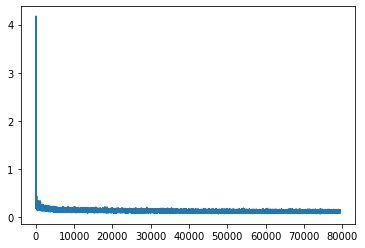

In [13]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [14]:
images = next(iter(dataloader)).to(device)

In [15]:
with torch.no_grad():
    z = encoder(images)
z = (z-z.min())/(z.max()-z.min())
z.requires_grad_(True)
z.retain_grad()
lr = 1e-2
optimizer = torch.optim.Adam([z], lr= lr)

criterion = torch.nn.MSELoss(reduction="sum")
epochs=1000

In [16]:
losses = []
for i in range(epochs):
    optimizer.zero_grad()
    out = G(z, step=step)
    loss = criterion(out, images)+0.002*criterion(model(out), model(images))#+1e-5*criterion(z, encoder(G(z, step=step)))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    if i % 20 == 0:
        print("iter {:04d}: y_error = {:03g}".format(i,
            loss.item()))

iter 0000: y_error = 38192.8
iter 0020: y_error = 17337.7
iter 0040: y_error = 15361.7
iter 0060: y_error = 14139.9
iter 0080: y_error = 13055
iter 0100: y_error = 12542.9
iter 0120: y_error = 12228.7
iter 0140: y_error = 11939.1
iter 0160: y_error = 11652.9
iter 0180: y_error = 11458.1
iter 0200: y_error = 11222.5
iter 0220: y_error = 11011.4
iter 0240: y_error = 10871.8
iter 0260: y_error = 10737.6
iter 0280: y_error = 10578.7
iter 0300: y_error = 10390
iter 0320: y_error = 10269.2
iter 0340: y_error = 10134.5
iter 0360: y_error = 9990.17
iter 0380: y_error = 9808.47
iter 0400: y_error = 9702.53
iter 0420: y_error = 9539.41
iter 0440: y_error = 9389.34
iter 0460: y_error = 9216.22
iter 0480: y_error = 9048.86
iter 0500: y_error = 8898.92
iter 0520: y_error = 8743.9
iter 0540: y_error = 8589.53
iter 0560: y_error = 8446.92
iter 0580: y_error = 8331.45
iter 0600: y_error = 8201.84
iter 0620: y_error = 8077.71
iter 0640: y_error = 7974.81
iter 0660: y_error = 7867.71
iter 0680: y_error 

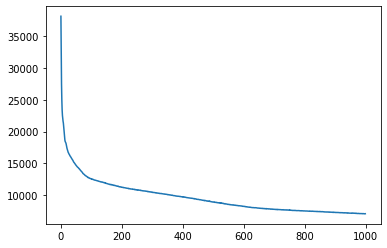

In [17]:
plt.plot(range(len(losses)), losses)

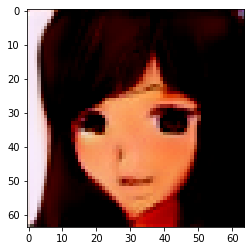

In [18]:
plt.imshow(out[0].detach().cpu().permute([1,2,0]).numpy())

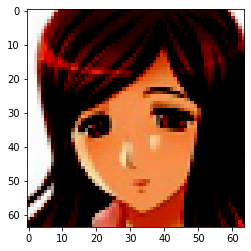

In [19]:
plt.imshow(images[0].cpu().permute([1,2,0]).numpy())

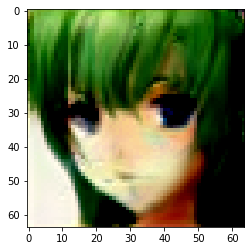

In [20]:
plt.imshow(out[D(out).argmax()].detach().cpu().permute([1,2,0]).numpy())

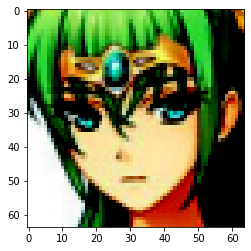

In [21]:
plt.imshow(images[D(out).argmax()].cpu().permute([1,2,0]).numpy())

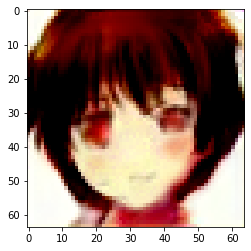

In [22]:
plt.imshow(out[2].detach().cpu().permute([1,2,0]).numpy())

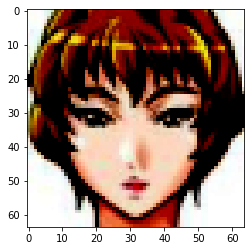

In [23]:
plt.imshow(images[2].cpu().permute([1,2,0]).numpy())

In [24]:
torch.save(encoder, "Encoder.pth")